In [1]:
import os
import warnings
import math
import weighted

import pandas as pd
import numpy as np
import statsmodels.api as sm

from tqdm import tqdm

from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
    get_derived_csv_path,
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
def transaction_period_to_date(transaction_period):
    """
    4th quarter 2020 -> (4, 2020)
    """
    split = transaction_period.split(" ")
    return int(split[0][0]), int(split[2])


def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [3]:
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in os.listdir(trade_prices_data_path)
]

In [4]:
req_int_columns = ["Transaction-price(total)", "Area(m^2)"]

req_float_columns = ["Transaction-price(Unit price m^2)"]

req_object_columns = [
    "City,Town,Ward,Village code",
    "Type",
    "Transaction period",
]

required_columns = req_int_columns + req_float_columns + req_object_columns

float_filler = dict((col, 0) for col in req_float_columns)
int_filler = dict((col, 0) for col in req_int_columns)
object_filler = dict((col, "na") for col in req_object_columns)
na_filler = {**float_filler, **int_filler, **object_filler}

In [5]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city["1101"]}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area["1100"]}") 

# In the future, we may want to use the 175 sub cities and just skip this
# Problem currently is that we don't have taxable income for sub cities
def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [6]:
def custom_aggregate(x):
    d = {}
    d["unit_price_wmean"] = np.average(x["unit_price"], weights=x["trade_area"])
    d["unit_price_wmedian"] = weighted.median(x["unit_price"], weights=x["trade_area"])
    d["unit_price_mean"] = x["unit_price"].mean()
    d["unit_price_median"] = x["unit_price"].median()
    d["total_traded_area"] = x["trade_area"].sum()
    d["count"] = x["count"].count()
    return pd.Series(
        d,
        index=[
            "unit_price_wmean",
            "unit_price_wmedian",
            "unit_price_mean",
            "unit_price_median",
            "total_traded_area",
            "count",
        ],
    )


def get_loess_parameters(
    area_code, area_to_diff_std, min_diff_std, max_diff_std, min_frac=0.3, max_frac=0.6
):
    diff_std = area_to_diff_std[area_code]
    diff_std = 1 if math.isnan(diff_std) else diff_std
    
    diff_score = (diff_std - min_diff_std) / (max_diff_std - min_diff_std)
    frac = min_frac + diff_score * (max_frac - min_frac)

    frac = min(frac, 0.8)
    frac = max(frac, 0.2)
    
    return (frac, 3, diff_score)

In [7]:
derived_dfs = {
    "land": pd.DataFrame(),
    "building": pd.DataFrame()
}

pbar = tqdm(total=len(trade_prices_data_paths))

# TODO: spatial and temporal smoothing
for path in trade_prices_data_paths:
    main_df = pd.read_csv(path, usecols=required_columns, encoding="unicode_escape")
    main_df = main_df.assign(count=1)

    main_df["area_code"] = main_df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    main_df["area_code"] = main_df["area_code"].apply(get_city_code).astype(str)
    main_df["area"] = main_df["area_code"].apply(get_area_from_area_code)

    main_df["trade_price"] = main_df["Transaction-price(total)"]
    main_df["trade_area"] = main_df["Area(m^2)"].apply(area_to_int)
    main_df["unit_price"] = main_df["Transaction-price(Unit price m^2)"]
    main_df["trade_price_per_area"] = main_df["trade_price"] / main_df["trade_area"]

    main_df[["quarter", "year"]] = pd.DataFrame(
        main_df["Transaction period"].apply(transaction_period_to_date).values.tolist(),
        columns=["quarter", "year"],
    )

    main_df["date"] = pd.PeriodIndex(
        year=main_df["year"], quarter=main_df["quarter"]
    ).to_timestamp()

    main_df["unit_price"] = np.where(
        main_df["unit_price"].isna(),
        main_df["trade_price_per_area"],
        main_df["unit_price"],
    )

    main_df = main_df.fillna(na_filler)

    for asset_type, asset_type_props in asset_types.items():
        df = main_df[main_df["Type"] == asset_type_props["label"]]
        df = (
            df.groupby(["year", "area_code", "area"])
            .apply(custom_aggregate)
            .reset_index()
        )
        df = df.sort_values(by=["year", "area_code"], ascending=[False, True]).reset_index(drop=True)
        derived_dfs[asset_type] = pd.concat([derived_dfs[asset_type], df])

    pbar.update()
pbar.close()

100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


In [54]:
# Temporal Smoothing

metrics = [
    "unit_price_wmean",
    "unit_price_wmedian",
    "unit_price_mean",
    "unit_price_median",
]

area_to_diff_std = {
    "land": {metric: {} for metric in metrics},
    "building": {metric: {} for metric in metrics},
}

area_to_loess_params = {
    "land": {metric: {} for metric in metrics},
    "building": {metric: {} for metric in metrics},
}

# Populate Area to Diff Std
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    area_codes = df["area_code"].unique()

    for area_code in area_codes:
        area_df = df[df["area_code"] == area_code]
        area_df = area_df.sort_values(by="year", ascending=True)

        for metric in metrics:        
            area_to_diff_std[asset_type][metric][area_code] = (
                area_df[metric].pct_change().std()
            )

# Populate LOESS Parameters
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    area_codes = df["area_code"].unique()

    for metric in metrics:
        area_to_diff_std_series = pd.Series(area_to_diff_std[asset_type][metric])
        min_diff_std = area_to_diff_std_series.quantile(0.05)
        max_diff_std = area_to_diff_std_series.quantile(0.95)

        for area_code in area_codes:
            area_to_loess_params[asset_type][metric][area_code] = get_loess_parameters(
                area_code,
                area_to_diff_std[asset_type][metric],
                min_diff_std,
                max_diff_std,
            )

# Smooth Data
for asset_type in asset_types:
    df = derived_dfs[asset_type]
    smoothed_df = pd.DataFrame()

    for area_code in df["area_code"].unique():
        area_df = df[df["area_code"] == area_code]
        area_df = area_df.sort_values(by="year", ascending=True)

        for metric in metrics:
            smoothed_metric = f"{metric}_smoothed"
            frac, it, _ = area_to_loess_params[asset_type][metric][area_code]
            area_df[smoothed_metric] = sm.nonparametric.lowess(
                area_df[metric], area_df.index, frac=frac, it=it, return_sorted=False
            )

        smoothed_df = pd.concat([smoothed_df, area_df])

    derived_dfs[asset_type] = smoothed_df

In [56]:
# Save derived dataframes
for asset_type, asset_type_props in asset_types.items():
    path = get_derived_csv_path(
        asset_type,
    )
    derived_dfs[asset_type].to_csv(
        path,
        index=False,
    )
    print(f"Wrote to {path}")

Wrote to ../../data/derived/transactions/land.csv
Wrote to ../../data/derived/transactions/building.csv


In [4]:
path = get_derived_csv_path(
    "land"
)
df = pd.read_csv(path)
df

,year,area_code,area,unit_price_wmean,unit_price_wmedian,unit_price_mean,unit_price_median,total_traded_area,count,unit_price_wmean_smoothed,unit_price_wmedian_smoothed,unit_price_mean_smoothed,unit_price_median_smoothed
0,2005,40100,Fukuoka-ken Kitakyushu-shi,72000.000000,72000.0,72000.000000,72000.0,300.0,1.0,71659.744503,71207.857884,71353.611621,50429.558574
1,2006,40100,Fukuoka-ken Kitakyushu-shi,51249.930925,42000.0,57018.676471,50000.0,269995.0,680.0,63490.448367,58251.668052,65456.068894,50127.671544
2,2007,40100,Fukuoka-ken Kitakyushu-shi,53931.733061,42000.0,59476.838440,50000.0,315540.0,718.0,53931.733061,42000.000000,58819.871807,49719.862974
3,2008,40100,Fukuoka-ken Kitakyushu-shi,50904.304957,41000.0,55842.469775,49000.0,262070.0,579.0,50904.304957,42143.075492,57490.269625,49726.345252
4,2009,40100,Fukuoka-ken Kitakyushu-shi,64746.628755,44000.0,57897.257384,50500.0,189915.0,474.0,50588.296233,42566.162036,56395.180367,50220.332611
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28320,2021,29449,Nara-ken Totsukawa-mura,4000.000000,4000.0,4000.000000,4000.0,340.0,1.0,6387.190612,7011.623429,6590.398804,7419.798171
28321,2007,29447,Nara-ken Nosegawa-mura,5500.000000,5500.0,5500.000000,5500.0,180.0,1.0,5500.000000,5500.000000,5500.000000,5500.000000
28322,2014,29447,Nara-ken Nosegawa-mura,4700.000000,4700.0,4700.000000,4700.0,2000.0,1.0,4700.000000,4700.000000,4700.000000,4700.000000
28323,2016,29447,Nara-ken Nosegawa-mura,1500.000000,1500.0,1500.000000,1500.0,850.0,1.0,1500.000000,1500.000000,1500.000000,1500.000000


In [58]:
# test_area = "1100" # Hokkaido Sapporo-shi
test_area = 13102 # Tokyo-to Chuo-ku

<Axes: xlabel='year'>

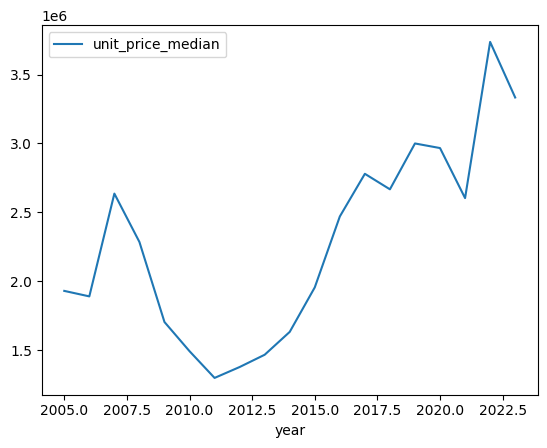

In [59]:
# median
df[df["area_code"] == test_area].plot(x="year", y="unit_price_median")

<Axes: xlabel='year'>

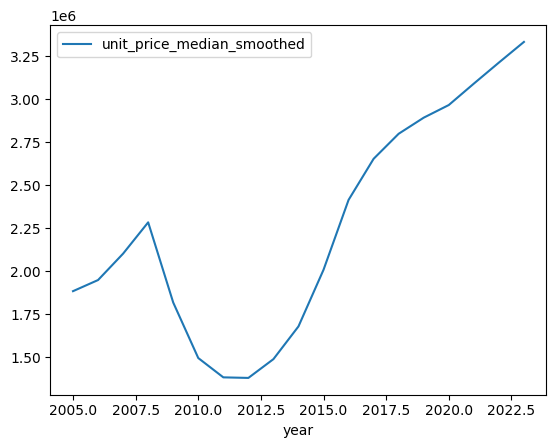

In [60]:
# median
df[df["area_code"] == test_area].plot(x="year", y="unit_price_median_smoothed")

<Axes: xlabel='year'>

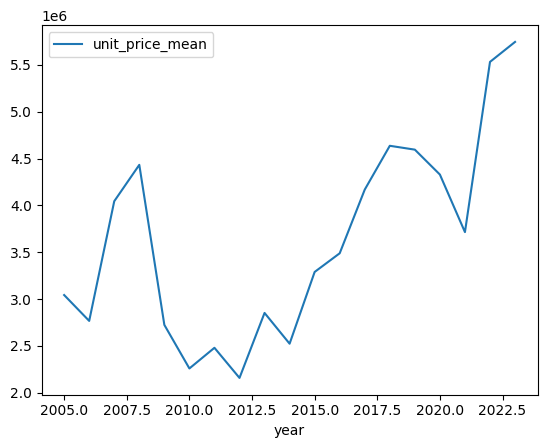

In [61]:
# mean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_mean")

<Axes: xlabel='year'>

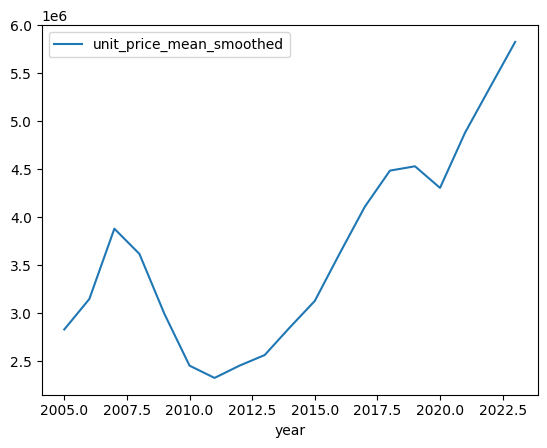

In [62]:
# mean
df[df["area_code"] == test_area].plot(x="year", y="unit_price_mean_smoothed")

<Axes: xlabel='year'>

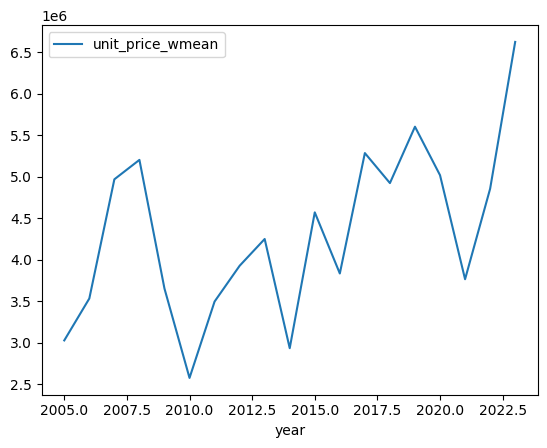

In [94]:
# weighted mean - this makes the most sense. Prices wouldn't be on the decline before the financial crisis
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmean")

<Axes: xlabel='year'>

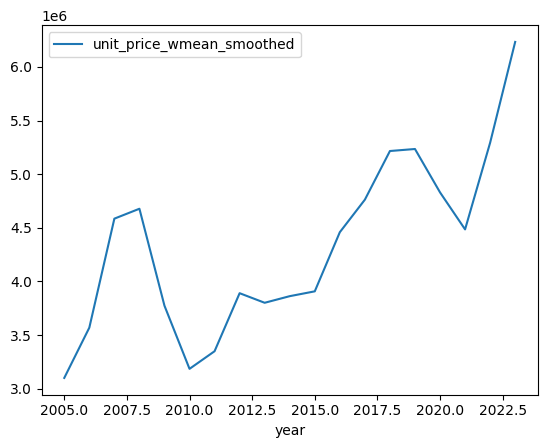

In [63]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmean_smoothed")

<Axes: xlabel='year'>

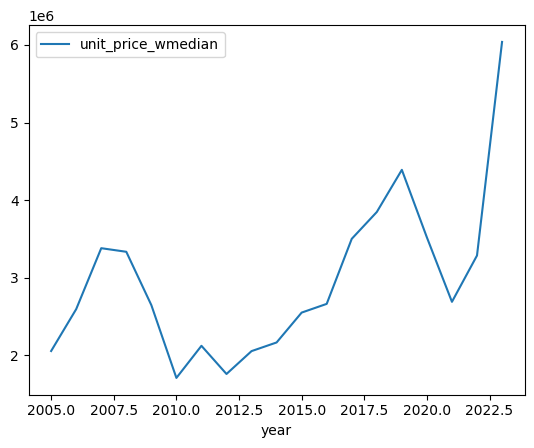

In [64]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmedian")

<Axes: xlabel='year'>

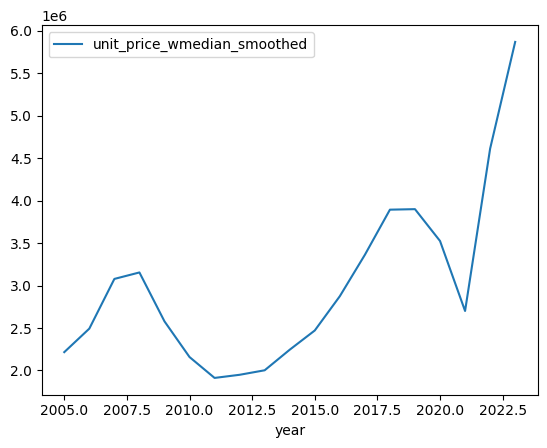

In [66]:
df[df["area_code"] == test_area].plot(x="year", y="unit_price_wmedian_smoothed")